In [55]:
import torch
from torch import nn
import torchvision as tv
from torchsummary import summary
import time
from torchvision.models import ResNet18_Weights, VGG16_Weights, Inception_V3_Weights, DenseNet161_Weights
import matplotlib.pyplot as plt

In [56]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [57]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [58]:
def train(net, train_iter, test_iter, trainer, num_epochs, losses_list):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. " 
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
              losses_list.append((i, train_l_sum / n))
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [59]:
BATCH_SIZE = 256

transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', train=True, split="balanced", transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', train=False, split="balanced", transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [60]:
model = tv.models.resnet18(weights=ResNet18_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(in_features=512, out_features=47)
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
trainer = torch.optim.Adam(params_to_update, lr=0.001)
resnet18_loss = []

In [61]:
train(model, train_iter, test_iter, trainer, 1, resnet18_loss)

Step 0. time since epoch: 6.255. Train acc: 0.027. Train Loss: 3.996
Step 10. time since epoch: 12.151. Train acc: 0.068. Train Loss: 3.728
Step 20. time since epoch: 17.594. Train acc: 0.141. Train Loss: 3.513
Step 30. time since epoch: 22.987. Train acc: 0.218. Train Loss: 3.307
Step 40. time since epoch: 28.326. Train acc: 0.272. Train Loss: 3.138
Step 50. time since epoch: 34.009. Train acc: 0.318. Train Loss: 2.983
Step 60. time since epoch: 39.366. Train acc: 0.355. Train Loss: 2.851
Step 70. time since epoch: 44.849. Train acc: 0.388. Train Loss: 2.731
Step 80. time since epoch: 50.206. Train acc: 0.414. Train Loss: 2.625
Step 90. time since epoch: 55.507. Train acc: 0.436. Train Loss: 2.527
Step 100. time since epoch: 60.916. Train acc: 0.457. Train Loss: 2.442
Step 110. time since epoch: 66.235. Train acc: 0.473. Train Loss: 2.364
Step 120. time since epoch: 71.628. Train acc: 0.488. Train Loss: 2.295
Step 130. time since epoch: 76.968. Train acc: 0.501. Train Loss: 2.233
Step

In [43]:
model = tv.models.vgg16(weights=VGG16_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(in_features=4096, out_features=47)
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
trainer = torch.optim.Adam(params_to_update, lr=0.001)
vgg16_loss = []

In [44]:
train(model, train_iter, test_iter, trainer, 1, vgg16_loss)

Step 0. time since epoch: 11.687. Train acc: 0.016. Train Loss: 3.920
Step 10. time since epoch: 56.526. Train acc: 0.115. Train Loss: 3.539


KeyboardInterrupt: 

In [48]:
model = tv.models.inception_v3(weights=Inception_V3_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(in_features=2048, out_features=47)
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
trainer = torch.optim.Adam(params_to_update, lr=0.001)
inception3_loss = []

In [ ]:
train(model, train_iter, test_iter, trainer, 1, inception3_loss)

In [49]:
model = tv.models.densenet161(weights=DenseNet161_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False
model.classifier = nn.Linear(in_features=2208, out_features=47)
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
trainer = torch.optim.Adam(params_to_update, lr=0.001)
densenet161_loss = []

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /Users/taraskvitko/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


100.0%


In [ ]:
train(model, train_iter, test_iter, trainer, 1, densenet161_loss)

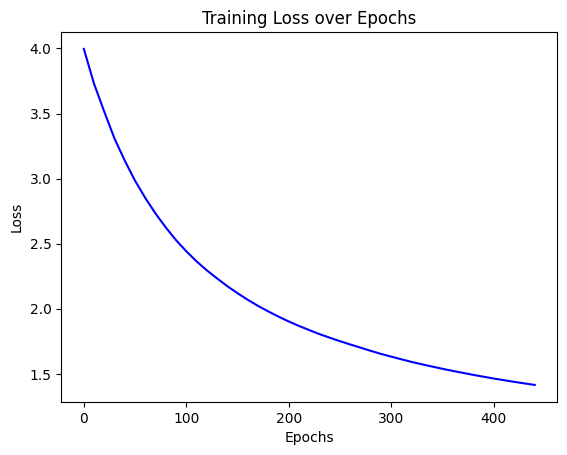

In [86]:
plt.figure()

steps = [data[0] for data in resnet18_loss]
loss = [data[1] for data in resnet18_loss]
plt.plot(steps, loss, 'b', label='resnet18_loss')

steps = [data[0] for data in vgg16_loss]
loss = [data[1] for data in vgg16_loss]
plt.plot(steps, loss, 'r', label='vgg16_loss')

steps = [data[0] for data in inception3_loss]
loss = [data[1] for data in inception3_loss]
plt.plot(steps, loss, 'g', label='inception3_loss')

steps = [data[0] for data in densenet161_loss]
loss = [data[1] for data in densenet161_loss]
plt.plot(steps, loss, 'y', label='densenet161_loss')

plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.legend()
plt.show()